<a href="https://colab.research.google.com/github/sokistar24/msc_project/blob/master/IEEE_publication_traffic_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Dec 16 22:11:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------



# *clone Repository for the traffic *







In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


# add all neccesary imports

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import random
import pickle
import pandas as pd
import cv2

In [ ]:
np.random.seed(0)

# load the traffic data here

In [ ]:
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
        test_data = pickle.load(f)

# spliting dataset into Train , Test And Validation

In [ ]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


## **Test** **the** **data** **set** **for** **completeness**

In [ ]:
 assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
 assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
 assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
 assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
 assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
 assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

# **Read** **Traffic** **sign** **Names** **and** **class** **ID**

In [ ]:
 data = pd.read_csv('german-traffic-signs/signnames.csv')
 print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

# **Visualizing** **Dataset**

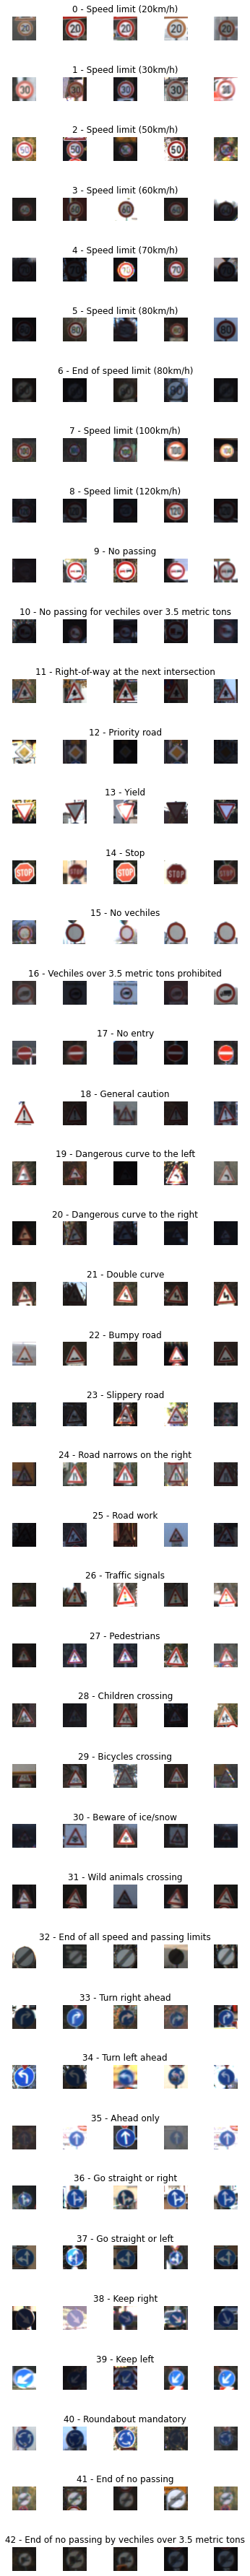

In [ ]:
num_of_samples=[]  
cols = 5
num_classes = 43  
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
     
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

# **Visualizing** **Distibution** **of** **Dataset**

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


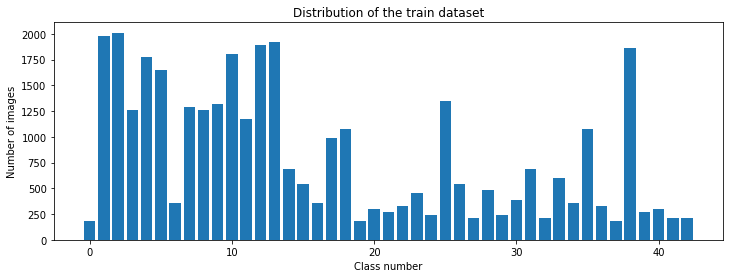

In [ ]:
    print(num_of_samples)
    plt.figure(figsize=(12, 4))
    plt.bar(range(0, num_classes), num_of_samples)
    plt.title("Distribution of the train dataset")
    plt.xlabel("Class number")
    plt.ylabel("Number of images")
    plt.show()

# **preprocessing** **Operation**

In [ ]:
def preprocess(img):
    #img =cv2.resize(img,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
    img = img/255
    return img

# **Applying** **Preprocessing** **Operation** **to** **the** **training** ,**testing** **and** **Validation** **dataset**

(34799, 32, 32, 3)


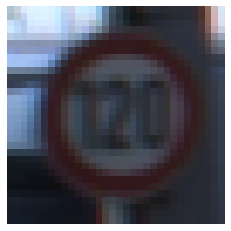

In [ ]:
X_train_rgb = np.array(list(map(preprocess, X_train)))
X_test_rgb = np.array(list(map(preprocess, X_test)))
X_val_rgb = np.array(list(map(preprocess, X_val)))
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

# **gray** **scale** **conversion** **of** **images**

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# **histogram** **equalization** 

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

In [ ]:
def preprocess_gray(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


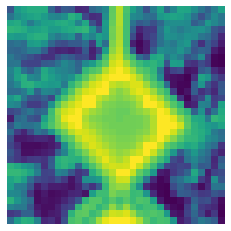

In [ ]:
X_train_gray = np.array(list(map(preprocess_gray, X_train)))
X_test_gray = np.array(list(map(preprocess_gray, X_test)))
X_val_gray = np.array(list(map(preprocess_gray, X_val)))
 
plt.imshow(X_train_gray[random.randint(0, len(X_train_gray) - 1)])
plt.axis('off')
print(X_train_gray.shape)

# **Reshaping** **data** **dimension** 

In [ ]:
X_train_gray = X_train_gray.reshape(34799, 32, 32, 1)
X_test_gray = X_test_gray.reshape(12630, 32, 32, 1)
X_val_gray = X_val_gray.reshape(4410, 32, 32, 1)

# **Gray** **Scale** **Augmentation**

In [ ]:
 from keras.preprocessing.image import ImageDataGenerator
     
 datagen_gray = ImageDataGenerator(width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.2,
                                shear_range=0.1,
                                rotation_range=10.)
     
 datagen_gray.fit(X_train_gray)

(5, 32, 32, 1)


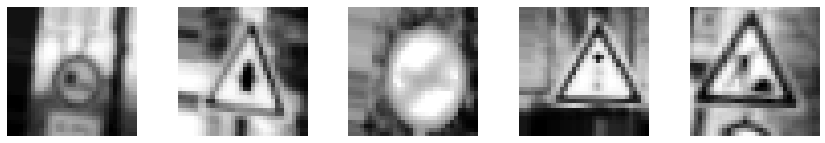

In [ ]:
batches_gray = datagen_gray.flow(X_train_gray, y_train, batch_size = 5) 
X_batch_gray, y_batch_gray = next(batches_gray)
     
fig, axs = plt.subplots(1, 5, figsize=(12, 12))
fig.tight_layout()
     
for i in range(5):
  axs[i].imshow(X_batch_gray[i].reshape((32, 32)),cmap='gray')
  axs[i].axis("off")
     
print(X_batch_gray.shape)

# **Augmentation** **for** **RGB** **images**

In [ ]:
 from keras.preprocessing.image import ImageDataGenerator
     
 datagen_rgb = ImageDataGenerator(width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.2,
                                shear_range=0.1,
                                rotation_range=10.)  
 datagen_rgb.fit(X_train_rgb)


(5, 32, 32, 3)


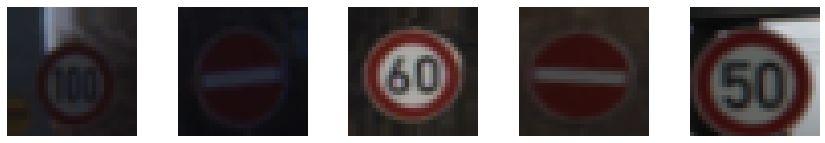

In [ ]:
batches_rgb = datagen_rgb.flow(X_train_rgb, y_train, batch_size = 5) 
X_batch_rgb, y_batch_rgb = next(batches_rgb)
     
fig, axs = plt.subplots(1, 5, figsize=(12, 12))
fig.tight_layout()
     
for i in range(5):
  axs[i].imshow(X_batch_rgb[i].reshape((32, 32,3)),cmap='gray')
  axs[i].axis("off")
     
print(X_batch_rgb.shape)

# **one** **hot** **encoding** **of** **labels**

In [ ]:
 y_train_cat = to_categorical(y_train, 43)
y_test_cat = to_categorical(y_test, 43)
y_val_cat = to_categorical(y_val, 43)

# VGG Model for the traffic signs

In [ ]:
vgg=VGG16(input_shape=(32,32,3),weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable= True
x=Flatten()(vgg.output)
Last_layer=Dense(43,activation='softmax')(x)
vgg_model=Model(inputs=vgg.input,outputs=Last_layer)
vgg_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

In [ ]:
vgg_model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg_history = vgg_model.fit_generator(datagen_rgb.flow(X_train_rgb, y_train_cat, batch_size=20),epochs=20,validation_data=(X_val_rgb, y_val_cat), shuffle = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1740/1740 [==============================] - 45s 26ms/step - loss: 2.7873 - accuracy: 0.2104 - val_loss: 1.5832 - val_accuracy: 0.4871
Epoch 2/20
1740/1740 [==============================] - 45s 26ms/step - loss: 1.2229 - accuracy: 0.5902 - val_loss: 0.8035 - val_accuracy: 0.7063
Epoch 3/20
1740/1740 [==============================] - 46s 26ms/step - loss: 0.6657 - accuracy: 0.7823 - val_loss: 0.5082 - val_accuracy: 0.8215
Epoch 4/20
1740/1740 [==============================] - 46s 26ms/step - loss: 0.4484 - accuracy: 0.8622 - val_loss: 0.3230 - val_accuracy: 0.9079
Epoch 5/20
1740/1740 [==============================] - 46s 26ms/step - loss: 0.2928 - accuracy: 0.9158 - val_loss: 0.3310 - val_accuracy: 0.9141
Epoch 6/20
1740/1740 [==============================] - 45s 26ms/step - loss: 0.2825 - accuracy: 0.9237 - val_loss: 0.2689 - val_accuracy: 0.9293
Epoch 7/20
1740/1740 [==========================

In [ ]:
score = vgg_model.evaluate(X_test_rgb, y_test_cat, verbose=0)
print(score)

[0.5368467569351196, 0.9268408417701721]


# Resnet50  Implimentation for traffic sign classification

In [ ]:
resnet=ResNet50(input_shape=(32,32,3),weights='imagenet',include_top=False)

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in resnet.layers:
  layer.trainable= True
x=Flatten()(resnet.output)
final_layer=Dense(43,activation='softmax')(x)
#prediction=Dense(1)(x)
resnet_model=Model(inputs=resnet.input,outputs=final_layer)
resnet_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
resnet_model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit_generator(datagen_rgb.flow(X_train_rgb, y_train_cat, batch_size=20),epochs=20,validation_data=(X_val_rgb, y_val_cat), shuffle = 1)

Epoch 1/20
1740/1740 [==============================] - 64s 37ms/step - loss: 3.0771 - accuracy: 0.2900 - val_loss: 13.6342 - val_accuracy: 0.2367
Epoch 2/20
1740/1740 [==============================] - 62s 36ms/step - loss: 2.2101 - accuracy: 0.4181 - val_loss: 5.3613 - val_accuracy: 0.4714
Epoch 3/20
1740/1740 [==============================] - 62s 36ms/step - loss: 1.5647 - accuracy: 0.5505 - val_loss: 4.3126 - val_accuracy: 0.4837
Epoch 4/20
1740/1740 [==============================] - 62s 36ms/step - loss: 1.1838 - accuracy: 0.6408 - val_loss: 6.6329 - val_accuracy: 0.4624
Epoch 5/20
1740/1740 [==============================] - 61s 35ms/step - loss: 0.8235 - accuracy: 0.7425 - val_loss: 0.5966 - val_accuracy: 0.8054
Epoch 6/20
1740/1740 [==============================] - 61s 35ms/step - loss: 0.4780 - accuracy: 0.8436 - val_loss: 0.6037 - val_accuracy: 0.8184
Epoch 7/20
1740/1740 [==============================] - 61s 35ms/step - loss: 0.4072 - accuracy: 0.8722 - val_loss: 0.3194 

In [ ]:
score = resnet_model.evaluate(X_test_rgb, y_test_cat, verbose=0)
print(score)

[0.2991679608821869, 0.9296120405197144]


# **Inception** **Model**

In [6]:
inception = InceptionV3(input_shape=(32,32,3),weights='imagenet',include_top=False)
for layer in inception.layers:
  layer.trainable= True
x=Flatten()(inception.output)
final_layer=Dense(43,activation='softmax')(x)
#prediction=Dense(1)(x)
inception_model=Model(inputs=inception.input,outputs=final_layer)
inception_model.summary()

ValueError: ignored

In [5]:
#resnet=ResNet50
#inception_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

# Modified AlexNet

In [ ]:
def modified_alexnet():
  model = Sequential()
  model.add(Conv2D(32, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  
  model.add(Flatten())
  model.add(Dense(600, activation='relu'))
  #model.add(BatchNormalization())
  model.add(Dense(400, activation='relu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
modified_alex = modified_alexnet()
print(modified_alex.summary())
 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 30)          17310     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 30)          8

In [ ]:
m_alex_history = modified_alex.fit_generator(datagen_gray.flow(X_train_gray, y_train_cat, batch_size=40),epochs=20,validation_data=(X_val_gray, y_val_cat), shuffle = 1)

Epoch 1/20
870/870 [==============================] - 12s 14ms/step - loss: 2.8174 - accuracy: 0.2357 - val_loss: 1.5119 - val_accuracy: 0.5565
Epoch 2/20
870/870 [==============================] - 12s 13ms/step - loss: 1.5444 - accuracy: 0.5465 - val_loss: 0.8534 - val_accuracy: 0.7476
Epoch 3/20
870/870 [==============================] - 12s 13ms/step - loss: 1.1258 - accuracy: 0.6638 - val_loss: 0.6441 - val_accuracy: 0.8088
Epoch 4/20
870/870 [==============================] - 12s 13ms/step - loss: 0.8836 - accuracy: 0.7342 - val_loss: 0.5110 - val_accuracy: 0.8431
Epoch 5/20
870/870 [==============================] - 12s 14ms/step - loss: 0.7422 - accuracy: 0.7762 - val_loss: 0.3953 - val_accuracy: 0.8789
Epoch 6/20
870/870 [==============================] - 12s 14ms/step - loss: 0.6320 - accuracy: 0.8073 - val_loss: 0.3466 - val_accuracy: 0.8873
Epoch 7/20
870/870 [==============================] - 12s 14ms/step - loss: 0.5441 - accuracy: 0.8374 - val_loss: 0.2945 - val_accuracy:

In [ ]:
score = modified_alex.evaluate(X_test_gray, y_test_cat, verbose=0)
print(score)

[0.26045092940330505, 0.9447347521781921]


# **plots** **section** 

Text(0.5, 0, 'epoch')

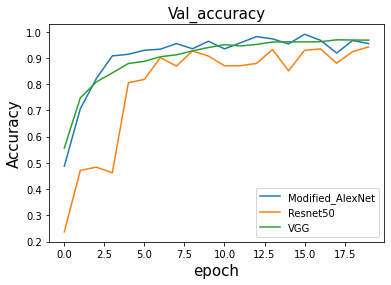

In [ ]:
plt.plot(vgg_history.history['val_accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.plot(m_alex_history.history['val_accuracy'])
plt.legend(['Modified_AlexNet','Resnet50','VGG'])
plt.title('Val_accuracy',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('epoch',fontsize=15)

Text(0, 0.5, 'Accuracy')

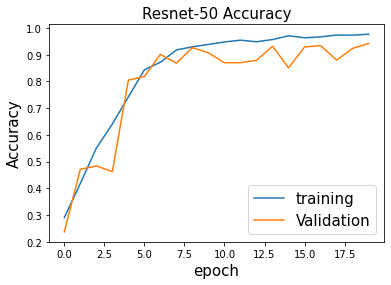

In [ ]:
# Resnet plots
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.legend(['training','Validation'],fontsize=15)
plt.title('Resnet-50 Accuracy',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)

Text(0, 0.5, 'Loss')

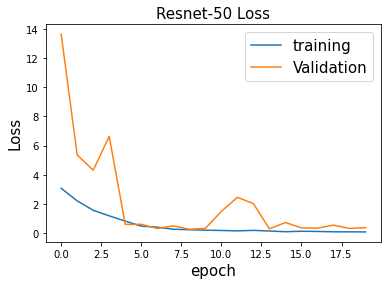

In [ ]:
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.legend(['training','Validation'],fontsize=15)
plt.title('Resnet-50 Loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
 

Text(0, 0.5, 'Accuracy')

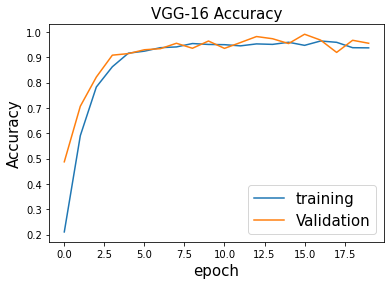

In [ ]:
# VGG plots
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.legend(['training','Validation'],fontsize=15)
plt.title('VGG-16 Accuracy',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)

Text(0, 0.5, 'Loss')

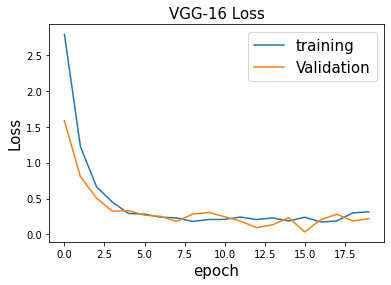

In [ ]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.legend(['training','Validation'],fontsize=15)
plt.title('VGG-16 Loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)

Text(0, 0.5, 'Accuracy')

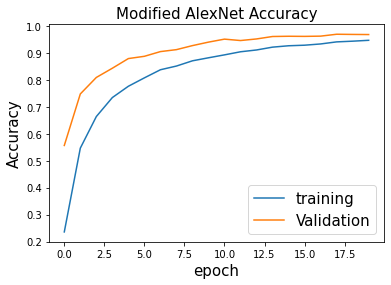

In [ ]:
#Modified Alexnet
plt.plot(m_alex_history.history['accuracy'])
plt.plot(m_alex_history.history['val_accuracy'])
plt.legend(['training','Validation'],fontsize=15)
plt.title('Modified AlexNet Accuracy',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)

Text(0, 0.5, 'Loss')

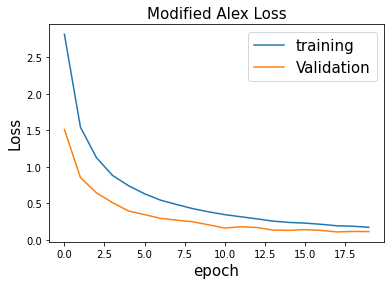

In [ ]:
plt.plot(m_alex_history.history['loss'])
plt.plot(m_alex_history.history['val_loss'])
plt.legend(['training','Validation'],fontsize=15)
plt.title('Modified Alex Loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
